In [ ]:
# 1. 설치(최초 1회) - timm이 없으면 주석 해제
# %pip install -q timm albumentations opencv-python scikit-learn torchmetrics

import os, sys, gc, math, random, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

try:
    import timm
except ImportError as e:
    print("timm가 필요합니다. 위 %pip 명령으로 설치하세요.")


In [5]:
# -------------------------
# 2) 설정
# -------------------------
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

DATA_DIR = "/kaggle/input/cat-and-dog"   # EC2라면 "./cat-and-dog"
OUT_DIR  = "./outputs_catsdogs"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 256            # OOM나면 192 → 128로
ACCUM_STEPS = 1
EPOCHS = 8
FOLDS = 5
LR = 3e-4
WEIGHT_DECAY = 2e-4
LABEL_SMOOTH = 0.1
MODEL_NAME = "tf_efficientnet_b0.ns_jft_in1k"

PRIMARY = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = PRIMARY
N_GPUS = torch.cuda.device_count()
USE_DP = False           # 안정화 기본값. True로 바꾸면 아래 DataParallel 사용
NUM_WORKERS = 4            # 너무 높이면 불안정할 수 있음
PREFETCH = 2
PERSISTENT = False         # 커널 크래시 방지 위해 기본 False

print(f"Device: {device}, #GPUs: {N_GPUS}, DP={USE_DP}")

Device: cuda:0, #GPUs: 1, DP=False


In [6]:
# -------------------------
# 3) 파일 인덱싱
# -------------------------
def list_images(root):
    patterns = [
        "training_set/**/*.jpg", "training_set/**/*.jpeg", "training_set/**/*.png",
        "train/**/*.jpg", "train/**/*.jpeg", "train/**/*.png",
        "test_set/**/*.jpg", "test_set/**/*.jpeg", "test_set/**/*.png",
        "test/**/*.jpg", "test/**/*.jpeg", "test/**/*.png",
        "*.jpg", "*.jpeg", "*.png",
    ]
    files = []
    for p in patterns: files.extend(Path(root).glob(p))
    files = [str(p) for p in files if p.is_file() and not p.name.startswith(".")]
    return sorted(list(set(files)))

def label_from_filename(path):
    name = Path(path).name.lower()
    stem = name.split('.')[0]
    if "dog" in stem or name.startswith("dog"): return 1
    if "cat" in stem or name.startswith("cat"): return 0
    parts = [p.lower() for p in Path(path).parts]
    if "dogs" in parts or "dog" in parts: return 1
    if "cats" in parts or "cat" in parts: return 0
    return None

all_files = list_images(DATA_DIR)
print(f"총 파일 수: {len(all_files)}")

rows = []
for f in all_files:
    y = label_from_filename(f)
    if y is None: 
        continue
    try:
        with Image.open(f) as im:
            im.verify()
        rows.append((f, y))
    except Exception:
        pass

df = pd.DataFrame(rows, columns=["filepath", "target"]).sort_values("filepath").reset_index(drop=True)
print(df.head(), df.tail(), df['target'].value_counts(), sep="\n\n")

총 파일 수: 10028
                                            filepath  target
0  /kaggle/input/cat-and-dog/test_set/test_set/ca...       0
1  /kaggle/input/cat-and-dog/test_set/test_set/ca...       0
2  /kaggle/input/cat-and-dog/test_set/test_set/ca...       0
3  /kaggle/input/cat-and-dog/test_set/test_set/ca...       0
4  /kaggle/input/cat-and-dog/test_set/test_set/ca...       0

                                                filepath  target
10023  /kaggle/input/cat-and-dog/training_set/trainin...       1
10024  /kaggle/input/cat-and-dog/training_set/trainin...       1
10025  /kaggle/input/cat-and-dog/training_set/trainin...       1
10026  /kaggle/input/cat-and-dog/training_set/trainin...       1
10027  /kaggle/input/cat-and-dog/training_set/trainin...       1

target
1    5017
0    5011
Name: count, dtype: int64


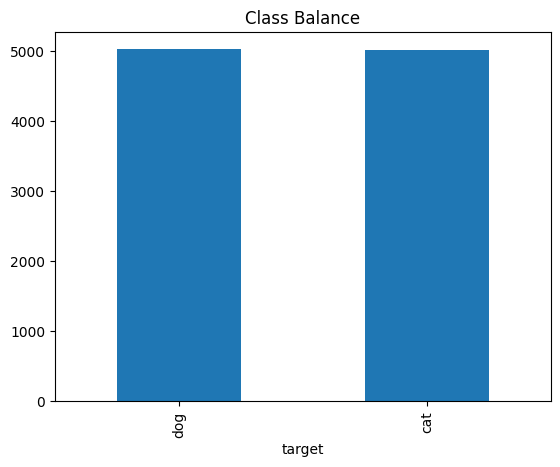

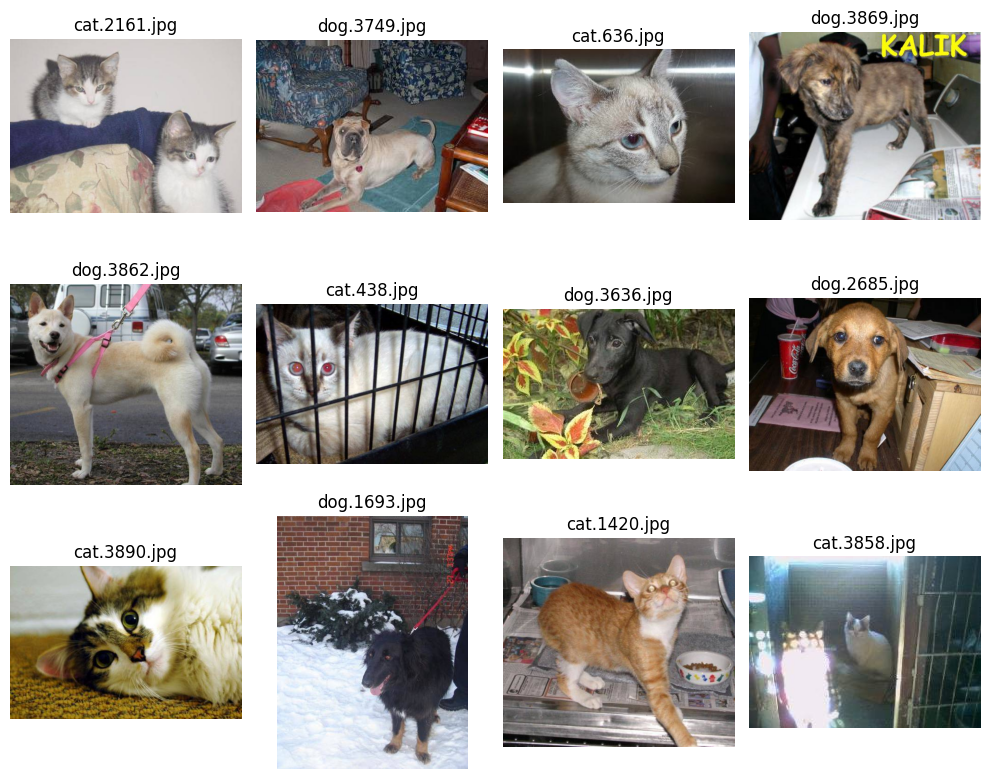

In [7]:
# -------------------------
# 4) (선택) 간단 EDA
# -------------------------
df['target'].map({0:'cat',1:'dog'}).value_counts().plot.bar(title="Class Balance"); plt.show()

sample_paths = df.sample(12, random_state=SEED)['filepath'].tolist()
plt.figure(figsize=(10,8))
for i,p in enumerate(sample_paths,1):
    img = Image.open(p).convert("RGB")
    plt.subplot(3,4,i); plt.imshow(img); plt.axis('off'); plt.title(Path(p).name[:20])
plt.tight_layout(); plt.show()

In [8]:
# -------------------------
# 5) 모델/옵티마이저
# -------------------------
def build_model(name=MODEL_NAME, num_classes=2, drop=0.2):
    model = timm.create_model(name, pretrained=True, num_classes=num_classes, drop_rate=drop)
    return model

def get_criterion(label_smoothing=LABEL_SMOOTH):
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing)

def get_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [9]:
# -------------------------
# 6) 변환/데이터로더
# -------------------------
from torchvision import transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
MEAN_STD = (IMAGENET_MEAN, IMAGENET_STD)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(*MEAN_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
])

valid_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(*MEAN_STD),
])

class ImageDataset(Dataset):
    def __init__(self, df, transforms):
        self.paths = df['filepath'].tolist()
        self.targets = df['target'].tolist()
        self.tfm = transforms
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        with Image.open(p).convert("RGB") as im:
            img = self.tfm(im)
        y = self.targets[i]
        return img, y

def make_loader(df, tfm, shuffle, bs=BATCH_SIZE):
    ds = ImageDataset(df, tfm)
    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle,
        num_workers=NUM_WORKERS, prefetch_factor=PREFETCH,
        pin_memory=True, persistent_workers=PERSISTENT
    )

In [10]:
# -------------------------
# 7) 학습 유틸
# -------------------------
class EarlyStopper:
    def __init__(self, patience=3, mode="max"):
        self.best = -1e9 if mode=="max" else 1e9
        self.patience = patience; self.counter = 0; self.mode = mode
    def step(self, metric):
        improved = (metric > self.best) if self.mode=="max" else (metric < self.best)
        if improved:
            self.best = metric; self.counter = 0; return True
        else:
            self.counter += 1; return False
    def should_stop(self): return self.counter >= self.patience

def run_one_epoch(model, loader, optimizer, scaler, criterion, train=True):
    model.train(train)
    if train: optimizer.zero_grad(set_to_none=True)

    total_loss, preds, gts = 0.0, [], []
    for step, (x, y) in enumerate(loader):
        x = x.to(PRIMARY, non_blocking=True).contiguous(memory_format=torch.channels_last)
        y = y.to(PRIMARY, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=True):
            logits = model(x)
            loss = criterion(logits, y) / ACCUM_STEPS
        if train:
            scaler.scale(loss).backward()
            if (step + 1) % ACCUM_STEPS == 0:
                scaler.step(optimizer); scaler.update()
                optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item() * ACCUM_STEPS
        preds.append(torch.argmax(logits, dim=1).detach().cpu().numpy())
        gts.append(y.detach().cpu().numpy())
    preds = np.concatenate(preds); gts = np.concatenate(gts)
    acc = accuracy_score(gts, preds); f1 = f1_score(gts, preds)
    return total_loss/len(loader), acc, f1

def clear_mem():
    gc.collect(); torch.cuda.empty_cache()

In [ ]:
# -------------------------
# 8) K-Fold: train/test 완전 분리
# -------------------------
is_test_path = df['filepath'].apply(lambda p: ('test' in Path(p).parts) or ('test_set' in Path(p).parts))
train_df = df[~is_test_path].reset_index(drop=True)
print("K-Fold 대상(train_df) 크기:", len(train_df))
print(train_df['target'].value_counts())

def has_test_path(df_):
    return df_['filepath'].apply(lambda p: any(t.lower() in {'test','test_set'} for t in Path(p).parts)).any()

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
X = train_df['filepath'].values
y = train_df['target'].values

fold_hist = []
best_fold_ckpts = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n========== Fold {fold}/{FOLDS} ==========")
    tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df.iloc[va_idx].reset_index(drop=True)
    assert not has_test_path(tr_df) and not has_test_path(va_df)

    train_loader = make_loader(tr_df, train_tfms, shuffle=True)
    valid_loader = make_loader(va_df, valid_tfms, shuffle=False)

    model = build_model(name=MODEL_NAME, num_classes=2, drop=0.2)
    model = model.to(PRIMARY).to(memory_format=torch.channels_last)
    if USE_DP and N_GPUS >= 2:
        model = nn.DataParallel(model, device_ids=list(range(N_GPUS)), output_device=0)

    criterion = get_criterion()
    optimizer = get_optimizer(model)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.amp.GradScaler('cuda', enabled=True)

    best_f1, best_path = -1.0, os.path.join(OUT_DIR, f"best_fold{fold}.pt")
    optimizer.zero_grad(set_to_none=True)
    stopper = EarlyStopper(patience=3, mode="max")

    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        tr_loss, tr_acc, tr_f1 = run_one_epoch(model, train_loader, optimizer, scaler, criterion, train=True)
        with torch.no_grad():
            va_loss, va_acc, va_f1 = run_one_epoch(model, valid_loader, optimizer, scaler, criterion, train=False)
        scheduler.step()

        print(f"Epoch {epoch:02d} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} "
              f"({time.time()-t0:.1f}s)")

        if va_f1 > best_f1:
            best_f1 = va_f1
            to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save({"model": to_save, "fold": fold, "epoch": epoch}, best_path)
            print(f"  ↳ Best updated (F1={best_f1:.4f}) → {best_path}")

        if not stopper.step(va_f1) and stopper.should_stop():
            print("  ↳ Early stopped.")
            break

    best_fold_ckpts.append(best_path)
    fold_hist.append({"fold": fold, "best_f1": best_f1})

    cv_path = os.path.join(OUT_DIR, "cv_summary.csv")
    pd.DataFrame(fold_hist).to_csv(cv_path, index=False)
    print(f"✅ Saved current CV summary → {cv_path}")
    print(pd.DataFrame(fold_hist))

    clear_mem()

K-Fold 대상(train_df) 크기: 8005
target
1    4005
0    4000
Name: count, dtype: int64

========== Fold 1/5 ==========


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 01 | train loss 0.7173 acc 0.8818 f1 0.8819 || val loss 0.4670 acc 0.9319 f1 0.9332 (86.2s)
  ↳ Best updated (F1=0.9332) → ./outputs_catsdogs/best_fold1.pt
Epoch 02 | train loss 0.4360 acc 0.9325 f1 0.9325 || val loss 0.3638 acc 0.9569 f1 0.9572 (35.1s)
  ↳ Best updated (F1=0.9572) → ./outputs_catsdogs/best_fold1.pt


테스트셋 샘플 수: 2023 (cats=1011, dogs=1012)
[CV] Using best fold from cv_summary.csv → ./outputs_catsdogs/best_fold1.pt

Test Classification Report
              precision    recall  f1-score   support

         cat     0.9881    0.9881    0.9881      1011
         dog     0.9881    0.9881    0.9881      1012

    accuracy                         0.9881      2023
   macro avg     0.9881    0.9881    0.9881      2023
weighted avg     0.9881    0.9881    0.9881      2023

Confusion Matrix:
 [[ 999   12]
 [  12 1000]]


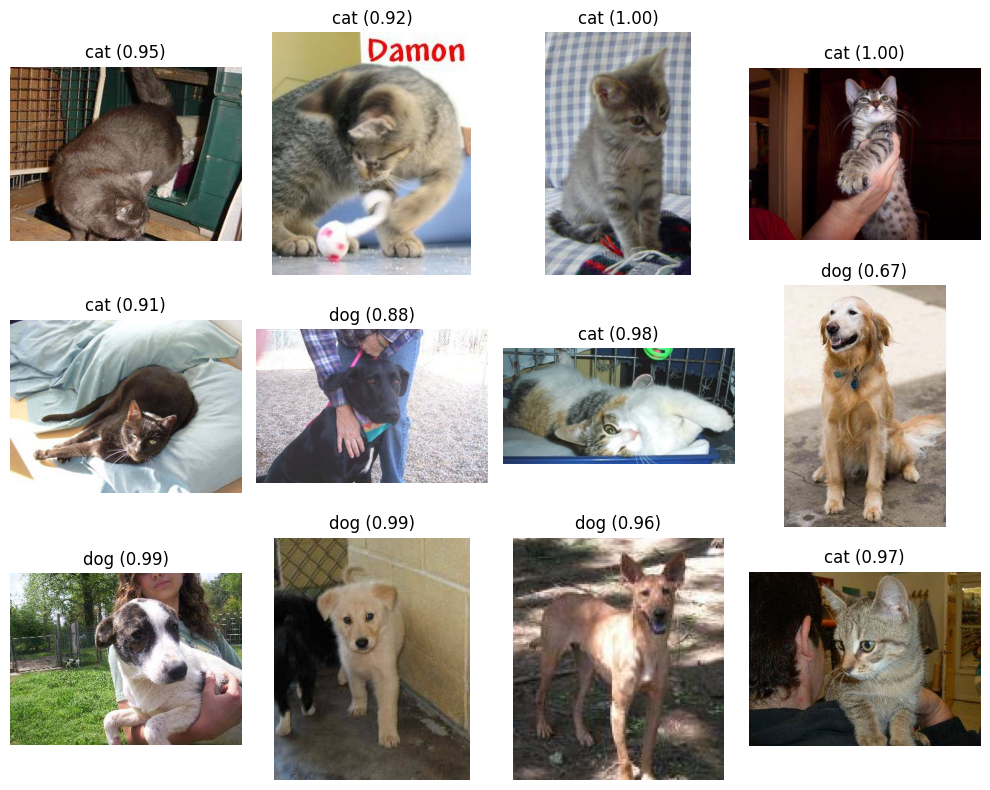

Best checkpoints: ['./outputs_catsdogs/best_fold1.pt', './outputs_catsdogs/best_fold2.pt']


,fold,best_f1
0,1,0.984962
1,2,0.978247


In [39]:
# -------------------------
# 9) 테스트셋 평가
# -------------------------
def filter_test_rows(df_all):
    paths = [p for p in df_all['filepath'].tolist() if "test" in Path(p).parts or "test_set" in Path(p).parts]
    test_df = df_all[df_all['filepath'].isin(paths)].reset_index(drop=True)
    return test_df

test_df = filter_test_rows(df)
if len(test_df) == 0:
    test_root = Path(DATA_DIR)/"test_set"
    alt = list_images(test_root)
    rows_t = [(str(p), label_from_filename(str(p))) for p in alt if label_from_filename(str(p)) is not None]
    test_df = pd.DataFrame(rows_t, columns=["filepath","target"])

print(f"테스트셋 샘플 수: {len(test_df)} (cats={sum(test_df.target==0)}, dogs={sum(test_df.target==1)})")
test_loader = make_loader(test_df, valid_tfms, shuffle=False)

# cv_summary.csv 안전 가드
cv_path = os.path.join(OUT_DIR, "cv_summary.csv")
if os.path.exists(cv_path):
    cv = pd.read_csv(cv_path)
    best_fold = int(cv.sort_values("best_f1", ascending=False).iloc[0]['fold'])
    best_ckpt = os.path.join(OUT_DIR, f"best_fold{best_fold}.pt")
    print("[CV] Using best fold from cv_summary.csv →", best_ckpt)
else:
    ckpts = sorted(glob.glob(os.path.join(OUT_DIR, "best_fold*.pt")))
    if not ckpts:
        raise FileNotFoundError(f"체크포인트가 없습니다. OUT_DIR={OUT_DIR}")
    best_ckpt = max(ckpts, key=os.path.getmtime)
    print(f"[WARN] cv_summary.csv not found. Using latest checkpoint: {best_ckpt}")

# 모델 로드 & 평가
model = build_model(name=MODEL_NAME, num_classes=2, drop=0.0)
state = torch.load(best_ckpt, map_location="cpu")["model"]
model.load_state_dict(state, strict=True)
model.to(device)
if N_GPUS >= 2:
    model = nn.DataParallel(model)
model.eval()

preds, gts = [], []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=True):
    for x,y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(pred); gts.append(y.numpy())
preds = np.concatenate(preds); gts = np.concatenate(gts)

print("\nTest Classification Report")
print(classification_report(gts, preds, target_names=["cat","dog"], digits=4))
print("Confusion Matrix:\n", confusion_matrix(gts, preds))

# 샘플 예측 시각화
sample = test_df.sample(12, random_state=SEED).reset_index(drop=True)
plt.figure(figsize=(10,8))
for i, row in sample.iterrows():
    img = Image.open(row.filepath).convert("RGB")
    t = valid_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        p = torch.softmax(model(t), dim=1)[0].cpu().numpy()
    pred_lbl = "dog" if p[1]>p[0] else "cat"; conf = p.max()
    plt.subplot(3,4,i+1); plt.imshow(img); plt.axis('off')
    plt.title(f"{pred_lbl} ({conf:.2f})")
plt.tight_layout(); plt.show()

print("Best checkpoints:", best_fold_ckpts)
if os.path.exists(cv_path):
    display(pd.read_csv(cv_path))

In [40]:
# fold별 best 모델 경로 리스트, CV 요약 확인
print("Best checkpoints:", best_fold_ckpts)
display(pd.read_csv(os.path.join(OUT_DIR, "cv_summary.csv")))


Best checkpoints: ['./outputs_catsdogs/best_fold1.pt', './outputs_catsdogs/best_fold2.pt']


,fold,best_f1
0,1,0.984962
1,2,0.978247
